maybe the problem is in using ctrl enter vs clicking on run cell? when you click on run cell, jupyter variables panel appear, which doesn't happen with ctrl enter. 

maybe the problem comes from having stats['acc']['ptp'] = stats['acc']['max'] - stats['acc']['min'] appear on get_normalization_stats function (i think this is how the guy did it) instead of in update_stats function. 


In [ ]:
#!pip3 install pandas
#!pip3 install matplotlib
#!pip3 install Pillow
#!pip3 install pyts
#!pip3 install tifffile

In [7]:
# Forays into deep learning: Transfer Learning and fast.ai. 

# BLOG POST https://towardsdatascience.com/foray-into-deep-learning-transfer-learning-and-fast-ai-ca0c44c03874
# REPO https://github.com/chr0nikler/HumanActivityRecognition
# PAPER http://kilyos.ee.bilkent.edu.tr/~billur/publ_list/cj14.pdf
# DATASET https://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities

# Data set characteristics: Multivariate time-series
# Attribute characteristics: Real
# Associated Tasks: Classification, Clustering
# Number of instances: 9120
# Number of attributes: 5625




In [1]:
from pyprojroot import here
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import numpy as np

First thing first is to inspect the data, see what it looks like. I don't care about where the data is right now, just want to see it. We will worry about the data layout and creating images from that stuff later.

In [2]:
# String object
data_path = './datap/b_1/sheep_1/segment_1'

# feature_labels = [
#     'sheep_name', 
#     'sheep_number', 
#     'year', 
#     'month', 
#     'day',
#     'hour',
#     'minutes',
#     'seconds',
#     'event'
# ]

# Dictionary 
predicted_labels_map = {
    'b_1': 'eating',
    'b_2': 'resting',
    'b_3': 'vigilance',
}


In [3]:
# DataFrame object
s01 = pd.read_csv(data_path, header = 0).filter(regex = 'acc', axis = 1)



In [4]:
s01
# 200 rows are due to 40Hz sampling frequency times 5 sec segment

,acc_x,acc_y,acc_z
0,0.911865,-0.203857,0.467773
1,0.791992,-0.083984,0.323975
2,0.779785,0.023926,0.299805
3,0.815918,0.035889,0.395996
4,0.839844,-0.095947,0.527832
...,...,...,...
195,0.803955,-0.203857,0.395996
196,0.791992,-0.251953,0.419922
197,0.791992,-0.323975,0.431885
198,0.815918,-0.359863,0.467773


Data frame looks as we expect it to. Some summary statistics to get a feel for the data

In [5]:
s01.describe()



,acc_x,acc_y,acc_z
count,200.000000,200.000000,200.000000
mean,0.853263,-0.203704,0.453842
std,0.054977,0.074180,0.079385
min,0.719971,-0.419922,0.275879
25%,0.815918,-0.230835,0.395996
50%,0.851807,-0.191895,0.455811
75%,0.887939,-0.167969,0.515869
max,0.995850,0.035889,0.659912


Expectations are that accelerations have larger numbers in general, but everything else is pretty small. The dataset will require normalization for proper image conversion. Lets graph some of the acceleration data, just for the T. 

200
range(0, 200)


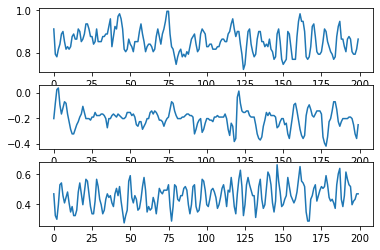

In [6]:
# where's this 'time' object being used??? doesn't seem to be used elsewhere
# len is an nrow
time = range(len(s01))
print(len(s01))
print(time)



plt.subplot(3,1,1)
plt.plot(s01['acc_x'])
plt.subplot(3,1,2)
plt.plot(s01['acc_y'])
plt.subplot(3,1,3)
plt.plot(s01['acc_z'])

Note the y axis is different, so on one graph this would look different, but the standard deviation is not too different, so the shapes look mostly the same (more action in the x and z axes than the y axis)

For now, let's branch off into just grabbing the acceleration stats. That's all I'm interested in right now. Later, if we want to use all the features, it should be trivial to account for the rest and produce image representations based on that, as long as our mapping is consistent

I use the simple strategy described in [this paper](https://www.researchgate.net/publication/259899616_Images_in_mind_-_Design_metaphor_and_method_to_classify_driver_distraction_in_critical_situations) to generate images from these variables. 
Steps necessary are

1. Normalize each feature BY SENSOR. If we normalize T_xacc separate from T_yacc, we lose the information that for some activity, there was a lot of acceleration in the x, but no y_acc (m' this is done by having the np.max determined across all columns, same with np.min, that is, the np.max is the max value of the whole data-frame containing the acc data, not the max of each column (acc axis)). This occurs per sensor type because gyroscopes, accelerometers, and magnetometers operate in different units. This also needs to be done by aggregating the data across all segments, not just per segment, because then information loss occurs between different activities. 
2. Convert range of [0,1] to [0,255] for grayscale
3. Save images 

What follows is a quick test of the above flow before tackling it across the data

In [7]:

# s01 is an object created by doing a read_csv on 'data_path 
# so all this is being done on only 1 segment of 1 person of 1 activity????? 
# yes but later there are functions that will applly to all segments of all 
# people of all activities

# 'step' objects created by me to understand the code 

# step 1 keeps columns that have 'acc' inside their name. 'axis=1' means to apply the filter to columns. We are left with 15 columns and 125 rows
# step1 = s01.filter(regex='acc$', axis=1)
# print(step1)

# step2 removes column names and just gives you the values
# step2 = step1.values
# print(step2)


# This step flattens row-wise (because of default arg-value of the function)
# step3 = step2.flatten()
# print(step3)

acceleration_data = s01.values.flatten()


print(acceleration_data)
# print(acceleration_data.shape) # this results in a vector of length 600, which equals 3 * 200  (3 acc axis * 200 rows)
# print(len(acceleration_data)) # same as with .shape









# in python a lambda function is an anonymous function. 
# ptp comes from "peak to peak". Gives range of values (maximum - minimum) along an axis. 
# pd.apply defaults to columns. wtf '1 or columns: applies to rows'
# this 'normalized' object does 2 things: normalization to 0-1 and then scaling to 0-255
#normalized = s01.apply(lambda x: 255 * (x - acceleration_data.min())/np.ptp(acceleration_data))
# normalized


[ 0.911865  -0.203857   0.467773   0.791992  -0.0839844  0.323975
  0.779785   0.0239258  0.299805   0.815918   0.0358887  0.395996
  0.839844  -0.0959473  0.527832   0.887939  -0.167969   0.539795
  0.899902  -0.119873   0.455811   0.851807  -0.0717773  0.407959
  0.815918  -0.0839844  0.443848   0.827881  -0.167969   0.47998
  0.815918  -0.227783   0.407959   0.827881  -0.287842   0.3479
  0.875977  -0.323975   0.383789   0.887939  -0.323975   0.323975
  0.86377   -0.287842   0.323975   0.86377   -0.251953   0.359863
  0.911865  -0.227783   0.47998    0.899902  -0.191895   0.539795
  0.851807  -0.167969   0.467773   0.86377   -0.10791    0.395996
  0.887939  -0.155762   0.47998    0.935791  -0.203857   0.563965
  0.935791  -0.203857   0.551758   0.911865  -0.203857   0.467773
  0.875977  -0.21582    0.383789   0.875977  -0.191895   0.335938
  0.839844  -0.191895   0.335938   0.851807  -0.155762   0.419922
  0.911865  -0.179932   0.563965   0.851807  -0.179932   0.515869
  0.851807  -

In [8]:

normalized.describe()


,acc_x,acc_y,acc_z
count,200.000000,200.000000,200.000000
mean,189.259292,73.788171,152.779505
std,14.802480,24.139981,22.606527
min,141.299088,0.000000,64.981001
25%,180.267922,60.089217,141.299088
50%,188.398738,75.541274,151.049487
75%,198.149273,89.307612,164.039189
max,230.639232,144.538255,255.000000


[[190 190 183 181 181 186 193 196 196 193 188 183 180 178 180 177 173 175
  183 186 188 188 185 188 181 177 178 170 191 204 204 201 170 154 167 191
  207 219 229 212 181 191 183 177 164 186 207 216 211 175 165 164 170 170
  175 188 194 188 188 188 191 186 190 194 203 181 175 173 175 186 191 183
  180 177 185 190 194 191 181 193 204 207 191 190 190 185 178 180 180 185
  193 201 203 212 207 183 172 170 173 177 194 212 216 201 177 180 190 188
  188 196 198 191 193 193 196 198 193 198 207 212 209 183 164 157 180 190
  194 186 209 201 188 188 181 180 190 201 201 191 203 209 198 190 212 222
  209 190 167 172 185 194 183 188 186 185 198 196 186 181 193 191 186 194
  198 198 209 216 214 206 194 188 180 186 181 172 152 144 141 147 211 230
  219 204 191 172 168 168 167 178 190 199 198 190 198 201 203 207 191 183
  183 175]
 [ 53  55  69  79  66  60  60  66  76  90  94  89  86  86 102 103 102  94
   76  38  45  60  66  86  86  84  82  69  81  77  84 115 116 113 129 144
  110 108  87  11   0  17  

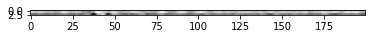

In [9]:

# print(data_path)
img_array = normalized.to_numpy().astype(np.uint8).T
print(img_array)


im = Image.fromarray(img_array)
# print(im)

plt.imshow(img_array, cmap='Greys')


im.save('a01p58s101.png') # I don't think this is right


The below, until the end, does the actual data reading, normalization, and image saving

In [21]:
# Initiate 'stats' dictionary for functions below
stats = {'acc': {}}


In [25]:
def update_stats(df):
    # Filter df to only contain acc columns, extract values, flatten, and then 
    # compute min and max stats
    acc_data = df.filter(regex='acc', axis=1).values.flatten()
    stats['acc']['min'] = acc_data.min()
    stats['acc']['max'] = acc_data.max()
    stats['acc']['ptp'] = stats['acc']['max'] - stats['acc']['min']


def get_normalization_stats(path):
    # Get all paths to segment files files
    for dirName, subDirs, fileList in os.walk(path):
        if('segment_1.txt' in fileList):
            for file in fileList:
                # Read data as csv and keep columns that contain 'acc'
                df = read_data(os.path.join(dirName,file))
                # compute min and max stats for all data
                update_stats(df)
    # compute peak to peak (ptp)
    #stats['acc']['ptp'] = stats['acc']['max'] - stats['acc']['min']

def create_images(data_path, save_path):
    
    for dirName, subDirs, fileList in os.walk(data_path):
        #if('segment_1.txt' in fileList):
            for file in fileList:
                # Create normalized df
                df = create_normalized_df(os.path.join(dirName,file))
                # Only care about acc right now.
                df = df.filter(regex='acc', axis=1)
                # Create image from df, create image name, and save in path
                save_image(df, os.path.join(dirName,file), save_path)
                
            
def save_image(df, original_path, save_path):
    # Create image name from original_path (e.g., 'eating_sheep_58_segment_101.png')
    image_name = create_image_name(original_path)
    # Create array of numbers
    img_array = df.to_numpy().astype(np.uint8).T
    # Create image from array
    im = Image.fromarray(img_array)
    # Save image
    im.save(os.path.join(save_path,image_name))
    
def create_image_name(original_path):
    # Create list with dirName, subDirs, and file 
    # (e.g., 'b_1, sheep_58, segment_101.txt')
    ## .split('/') will give us the list of strings between `/`
    ## the [2:] will keep from the 3rd value on. i.e., leave out the '.' and 'datap'
    unlabeled_data = original_path.split('/')[2:]
    # Replace dirName with predicted_labels_map (e.g., 'b_1' with 'eating')
    unlabeled_data[0] = predicted_labels_map[unlabeled_data[0]].replace(' ', '_')
    # Join unlabeled_data elements using '_' as separator,  and
    # replace '.txt' with '.png'
    return'_'.join(unlabeled_data).replace('.txt', '.png')
            
def read_data(path):
    # Read data as csv and keep those columns that contain 'acc'
    return pd.read_csv(path, header=0).filter(regex='acc', axis=1)
      
def create_normalized_df(path):
        ## TODO reject column_regex if it is not one of
        # acc$, gyro$, mag$, reject
        df = read_data(path)
        #column_key = regex[:len(regex)-1]
        acc_df = df.filter(regex='acc', axis=1).apply(lambda x: round(255 * (x - stats['acc']['min'])/stats['acc']['ptp']))
        
        return acc_df
         

In [39]:
# !pwd
# data_path = './datap/b_1/sheep_58/segment_101'
# s01 = pd.read_csv(data_path, header = 0).filter(regex = 'acc', axis = 1)
df = pd.read_csv('./datap/b_1/sheep_1/segment_1', header=0).filter(regex='acc', axis=1) 
# print(df)
acc_data = df.filter(regex='acc', axis=1)#.values.flatten()
# print(acc_data)
stats['acc']['min'] = acc_data.min()
stats['acc']['max'] = acc_data.max()
stats['acc']['ptp'] = stats['acc']['max'] - stats['acc']['min']

so this stats thing seems to work for './datap/b_1/sheep_1/segment_1' but not in the function, and the function seems to be right. Maybe the fail happens with a certain file? 
Lets check it with a loop

In [19]:

# for dirName, subDirs, fileList in os.walk(data_path):
#     if('segment_1.txt' in fileList): # delete this to check if it works
#         for file in fileList:
#             # Create normalized df
#             df = create_normalized_df(os.path.join(dirName,file))


# for dirName, subDirs, fileList in os.walk(data_path):
#     if('segment_1.txt' in fileList): # delete this to check if it works
#         print("YEAH")

data_path = './datap'
walked_paths = os.walk(data_path)

In [26]:
!pwd
data_path = './datap'
save_path = './images'
get_normalization_stats(data_path)



/home/franfram/AAR-DL


KeyError: 'max'

We can see that the stats have been populated. With them, we'll normalized each segement of data and create an image for it. 

**Note**: I've read that using ptp can be dangerous if there is a 0 difference array, and that borrowing `minmax_scale` from sklearn might be more appropriate.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [23]:
create_images(data_path, save_path)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

In [36]:
# Testing the problem if there's a 0 difference array and we are using np.ptp instead of sklearn.minmax_scale


test = pd.DataFrame(np.array([[1, 1], [1, 1]]))
ptpobject = np.ptp(test)
print(ptpobject) # not sure why I don't get all 0s and get one 1 

# there's no aparent problem in the function itself, the problem may arise when we normalize, because we would be dividing by 0. Maybe sklearn.mimax_scale gives
# default value when the difference is 0?

print(1 / ptpobject)


from sklearn import preprocessing


skobject = preprocessing.minmax_scale(test)
print(skobject) # here I do get all 0's

print(1 / skobject)

0    0
1    0
dtype: int64
0    inf
1    inf
dtype: float64
[[0. 0.]
 [0. 0.]]
[[inf inf]
 [inf inf]]


/home/franfram/anaconda3/envs/aar/lib/python3.10/site-packages/numpy/core/_methods.py:276: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  umr_maximum(a, axis, None, out, keepdims),
/home/franfram/anaconda3/envs/aar/lib/python3.10/site-packages/numpy/core/_methods.py:277: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  umr_minimum(a, axis, None, None, keepdims),
/tmp/ipykernel_9183/1844868659.py:20: RuntimeWarning: divide by zero encountered in true_divide
  print(1 / skobject)
